**Indicadores de Educación, Ciencia, Tecnología e Innovación**

In [ ]:
#rm(list=ls()) #limpa el entorno de trabajo

#LIBRERIAS
libraries <- c("tidyverse",
               "readr", 
               "srvyr",
               "showtext", 
               "haven", 
               "openxlsx", 
               "tidyr")

installed_packages <- rownames(installed.packages())
libraries_to_install <- setdiff(libraries, installed_packages)

if (length(libraries_to_install) > 0) {
  install.packages(libraries_to_install)}

lapply(libraries, library, character.only = TRUE)

In [37]:
#CONSIDERACIONES
#Tiempo de espera para la descarga
options(timeout = 8000)
#Fuente Roboto
font_add_google(name = "Roboto", family = "Roboto")
showtext_auto()

*Tasa de cobertura bruta de educación media superior e inicial*

In [38]:
#Carga datos de CONAPO
conapo<-read_csv("https://conapo.segob.gob.mx/work/models/CONAPO/Datos_Abiertos/pry23/00_Pob_Mitad_1950_2070.csv")%>%
  janitor::clean_names()|>
  filter(cve_geo==9)|>
group_by(ano,edad)|>
    summarise(poblacion= sum(poblacion))|>
mutate(tipo=case_when(edad>=15 & edad<=17 ~ "MEDIA SUPERIOR",
      edad>=0 & edad<=2 ~ "INICIAL CIUDAD DE MÉXICO"))|> #"INICIAL CIUDAD DE MÉXICO"
filter(!is.na(tipo))|>
group_by(ano,tipo)|>
summarise(poblacion=sum(poblacion))

unique(conapo$tipo) # Verifica los tipos de educación

Rows: 737660 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ENTIDAD, SEXO
dbl (5): RENGLON, AÑO, CVE_GEO, EDAD, POBLACION

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'ano'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'ano'. You can override using the `.groups`
argument.


[1] "INICIAL CIUDAD DE MÉXICO" "MEDIA SUPERIOR"

In [39]:
##Leer datos de SEP
sep<-openxlsx::read.xlsx("https://www.planeacion.sep.gob.mx/Doc/estadistica_e_indicadores/serie_historica_entidades_sep.xlsm",sheet = 1)|>
janitor::clean_names()%>%
  { 
    colnames(.) <- as.character(.[2, ])
    .[-2, ]
  } |>
  as.data.frame()|>
janitor::clean_names()|>
  rename(entidad = 1,
         tipo= 3
         )|>
 filter(entidad=="9",
    tipo %in% c("MEDIA SUPERIOR" , "INICIAL CIUDAD DE MÉXICO"))|> #"INICIAL CIUDAD DE MÉXICO"
#Eliminar columnas 1,2 y 4
select(-c(1,2,4))|>
#Llevar los datos a long
pivot_longer(cols = -c(tipo), names_to = "ciclo", values_to = "matricula")|>
#Eliminar x de ciclo
mutate(ciclo=str_replace(ciclo,"x",""),
#Seleccionar año inicial del ciclo
ano=as.numeric(str_sub(ciclo,1,4)),
matricula=as.numeric(matricula))|>
#Pegar con datos de CONAPO utilizando la variable tipo y ano
left_join(conapo,by=c("tipo","ano"))|>
#Calcular tasa de cobertura
mutate(tbcob=matricula/poblacion*100)

unique(sep$tipo)

[1] "INICIAL CIUDAD DE MÉXICO" "MEDIA SUPERIOR"

*Tasa de cobertura bruta de educación media superior*

In [40]:
#tasa de cobertura media superior
sep_med_sup<-sep|>
  filter(tipo=="MEDIA SUPERIOR")|>
  filter(ano>2019 &  ano < 2024)|>
  select(-tipo, -ciclo)|>
mutate(tipo = "Observado")

sep_med_sup

matricula,ano,poblacion,tbcob,tipo
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
455030,2020,403534,112.7613,Observado
460143,2021,395608,116.3129,Observado
452717,2022,389088,116.3534,Observado
449729,2023,383358,117.3131,Observado


In [47]:
#ESCENARIOS
#TASAS GENERLES PARA CADA PERIODO
tcob_base <- sep_med_sup|>
  filter(ano == 2023)|>
  pull(tbcob)

#Tasa de crecimiento media anual para el periodo 2020-2023
ano = (2024:2045)
año_base <- 2023
tcma<-((sep_med_sup$tbcob[sep_med_sup$ano==2023]/sep_med_sup$tbcob[sep_med_sup$ano==2020])^(1/(2023-2020))-1)
tcma

#Tasas de cobertura para los años 2030, 2035 y 2045 (estas tasas son las metas establecidas por la SECTEI)
#Metas establecidas por la SECTEI
cobertura <- data.frame(ano = c(2030, 2035, 2045), 
                        tbcob = c(119, 121, 125))
tcob_bse <- sep_med_sup|>
  filter(ano == 2023)
  t2030<-cobertura|>
filter(ano == 2030)
t2035<-cobertura|>
filter(ano == 2035)
t2045<-cobertura|>
filter(ano == 2045)

tc1= (t2030$tbcob / tcob_bse$tbcob)^(1 / (2030 - 2023)) - 1
tc2= (t2035$tbcob / t2030$tbcob)^(1 / (2035 - 2030)) - 1
tc3= (t2045$tbcob / t2035$tbcob)^(1 / (2045 - 2035)) - 1

tc1
tc2
tc3

[1] 0.01327849

[1] 0.002041711

[1] 0.003338972

[1] 0.003257614

In [ ]:
#Población de media superior conapo, años 2024 a 2045
proyecciones_med_sup <- data.frame(
  ano = 2024:2045) |>
  mutate(tbcob = ifelse(ano < 2030,tcob_bse$tbcob * (1 + tc1)^(ano - tcob_bse$ano),
                         ifelse(ano == 2030, t2030$tbcob,
                                ifelse(ano < 2035, t2030$tbcob * (1 + tc2)^(ano - t2030$ano),
                                        ifelse(ano == 2035, t2035$tbcob,
                                                ifelse(ano < 2045, t2035$tbcob * (1 + tc3)^(ano - t2035$ano),
                                                       ifelse(ano == 2045, t2045$tbcob, 0)))))))|>
                                                       mutate(tipo = "Deseable")

#ESTABLECIMIENTO DE LAS TENEDENCIAS (ESCENARIO INERCIAL Y TRANSFORMADOR)
tendencia_base <- data.frame(ano = ano,
                             tbcob = round(tcob_base * (1 + tcma ) ^ (ano - año_base), 2),
                             tipo = "Inercial")

tendencia_transformador <- data.frame(ano = ano,
                                       tbcob = round(tcob_base * (1 + tcma+.002 ) ^ (ano - ano_base), 2),
                                       tipo = "Transformador")

In [51]:
sep_med_sup_proy <- sep_med_sup |>
  select(ano, tipo, tbcob)|>
  bind_rows(proyecciones_med_sup, tendencia_base, tendencia_transformador)

  sep_med_sup_proy

ano,tipo,tbcob
<dbl>,<chr>,<dbl>
2020,Observado,112.7613
2021,Observado,116.3129
2022,Observado,116.3534
2023,Observado,117.3131
2024,Deseable,117.5526
2025,Deseable,117.7926
2026,Deseable,118.0331
2027,Deseable,118.2741
2028,Deseable,118.5156


In [53]:
lineas <- bind_rows(data.frame(ano = c(2023, 2030),
                               tbcob = c(sep_med_sup_proy$tbcob[sep_med_sup_proy$ano == 2023 & sep_med_sup_proy$tipo == "Observado"],
                                              sep_med_sup_proy$tbcob[sep_med_sup_proy$ano == 2030 & sep_med_sup_proy$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2023, 2030),
                               tbcob = c(sep_med_sup_proy$tbcob[sep_med_sup_proy$ano == 2023 & sep_med_sup_proy$tipo == "Observado"], 
                                              sep_med_sup_proy$tbcob[sep_med_sup_proy$ano == 2030 & sep_med_sup_proy$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2023, 2030),
                               tbcob = c(sep_med_sup_proy$tbcob[sep_med_sup_proy$ano == 2023 & sep_med_sup_proy$tipo == "Observado"], 
                                              sep_med_sup_proy$tbcob[sep_med_sup_proy$ano == 2030 & sep_med_sup_proy$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")

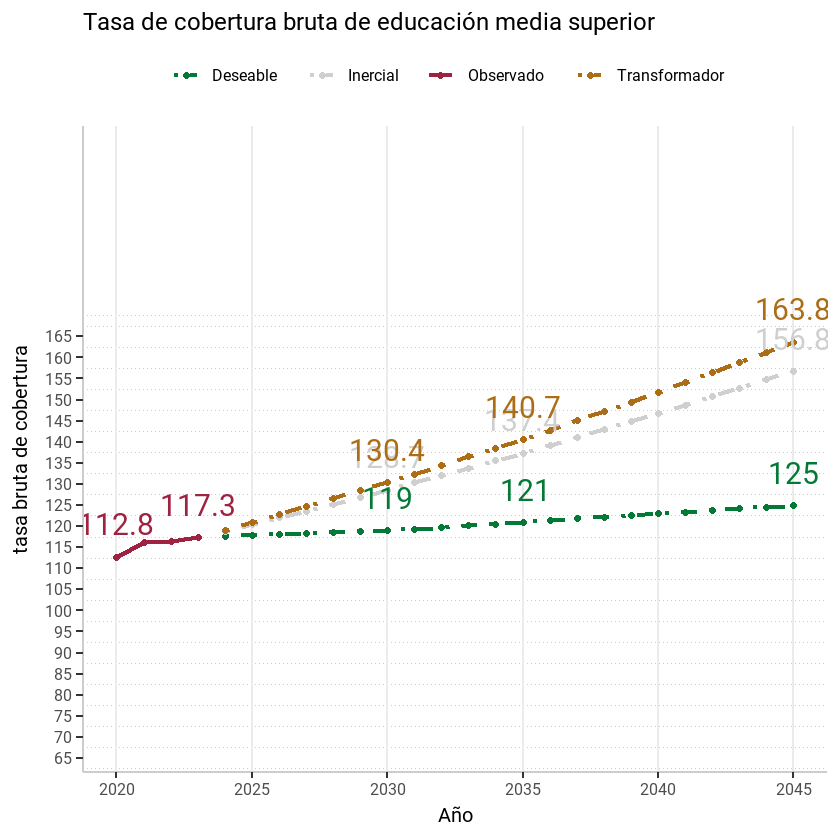

In [ ]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(sep_med_sup_proy, aes(x = ano, y = tbcob, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
geom_text(data = subset(sep_med_sup_proy, ano %in% c(2020, 2023, 2030, 2035, 2045)),
          aes(label = paste0(round(tbcob, 1), "")),
          vjust = -1, size = 8, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(sep_med_sup_proy$tbcob, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, ""),
                     expand = expansion(mult = c(1, 1))) +
  labs(title = "Tasa de cobertura bruta de educación media superior",
       x = "Año",
       y = "tasa bruta de cobertura",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

# Guardar el gráfico
#ggsave("tasa_cobertura_media_superior.png", width = 12, height = 8, dpi = 300)
         

*Tasa de cobertura bruta de educación inicial*

In [136]:
#tasa de cobertura media inicialerior
sep_inicial<-sep|>
  filter(tipo=="INICIAL PÚBLICO")
  
sep_inicial

tipo,ciclo,matricula,ano,poblacion,tbcob
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
INICIAL PÚBLICO,1990_1991,NA,1990,571443,NA
INICIAL PÚBLICO,1991_1992,NA,1991,558938,NA
INICIAL PÚBLICO,1992_1993,NA,1992,549389,NA
INICIAL PÚBLICO,1993_1994,NA,1993,539694,NA
INICIAL PÚBLICO,1994_1995,NA,1994,528980,NA
INICIAL PÚBLICO,1995_1996,NA,1995,516994,NA
INICIAL PÚBLICO,1996_1997,NA,1996,504812,NA
INICIAL PÚBLICO,1997_1998,NA,1997,494056,NA
INICIAL PÚBLICO,1998_1999,NA,1998,485294,NA


In [ ]:
#Metas establecidas por la SECTEI
cobertura <- data.frame(
  ano = c(2030, 2035, 2045), 
  tbcob = c(1, 3, 5))

#TASAS GENERLES PARA CADA PERIODO
año_base <- sep_inicial|>
  filter(ano == 2023)
  
#Tasas de cobertura para los años 2030, 2035 y 2045 (estas tasas son las metas establecidas por la SECTEI)
t2030<-cobertura|>
filter(ano == 2030)
t2035<-cobertura|>
filter(ano == 2035)
t2045<-cobertura|>
filter(ano == 2045)

tc1= (t2030$tbcob / año_base$tbcob)^(1 / (2030 - 2023)) - 1
tc2= (t2035$tbcob / t2030$tbcob)^(1 / (2035 - 2030)) - 1
tc3= (t2045$tbcob / t2035$tbcob)^(1 / (2045 - 2035)) - 1

tc1
tc2
tc3

In [ ]:
#Proyecciones de la tasa de cobertura inicial, años 2024 a 2045
proyecciones_inicial <- data.frame(
  ano = 2024:2045) |>
  mutate(tbcob = ifelse(ano < 2030,año_base$tbcob * (1 + tc1)^(ano - año_base$ano),
                         ifelse(ano == 2030, t2030$tbcob,
                                ifelse(ano < 2035, t2030$tbcob * (1 + tc2)^(ano - t2030$ano),
                                        ifelse(ano == 2035, t2035$tbcob,
                                                ifelse(ano < 2045, t2035$tbcob * (1 + tc3)^(ano - t2035$ano),
                                                       ifelse(ano == 2045, t2045$tbcob, 0)))))))


sep_med_inicial_proy <- sep_inicial |>
  select(ano, tbcob)|>
  bind_rows(proyecciones_med_inicial)

sep_inicial_proy

*Porcentaje de patentes solicitadas por personas mexicanas*

In [63]:
impi <- read_csv("https://datosabiertos.impi.gob.mx/IMPICifras/Invenciones03.csv", 
                 col_names = FALSE, show_col_types = FALSE)
# Procesar datos de IMPI
impi <- impi |>
  # Eliminar las primeras 4 filas y renombrar las columnas
  slice(5:n())|>                            
  set_names(as.character(impi[5, ])) |>     
  janitor::clean_names() |>                
  slice(-1)|>
rename(entidad=2)|>
filter(entidad=="Ciudad de México" | entidad=="Total / Total")|>
#Dejar columna entidad y todas aquellas que contengan "patentes"
select(entidad,contains("patentes"))|>
#Transformar columnas patentes a numérico
#Eliminar comas de los números
mutate(across(contains("patentes"), ~ as.numeric(str_replace_all(., ",", ""))) )|>
# #Calcular porcentaje de patentes
mutate(across(contains("patentes"), ~ . / .[entidad == "Total / Total"] * 100))|>
filter(entidad=="Ciudad de México")|>
# #Long
pivot_longer(cols = -entidad, names_to = "tipo", values_to = "porcentaje")|>
#Crear variable año de 1993 hasta que se terminan las columnas
mutate(ano = 1993:(1993 + n() - 1))|>
filter(ano < 2025)|>
select(ano, porcentaje)|>
mutate(tipo = "Observado")


impi

ano,porcentaje,tipo
<int>,<dbl>,<chr>
1993,48.82459,Observado
1994,42.36948,Observado
1995,46.06481,Observado
1996,40.67358,Observado
1997,37.61905,Observado
1998,40.17660,Observado
1999,40.21978,Observado
2000,38.97912,Observado
2001,40.44944,Observado


In [69]:
#ESCENARIOS
#TASAS GENERLES PARA CADA PERIODO
porcentaje_base <- impi|>
  filter(ano == 2024)|>
  pull(porcentaje)

#Tasa de crecimiento media anual para el periodo 2020-2024
ano = (2024:2045)
ano_base <- 2024
tcma<-((impi$porcentaje[impi$ano==2024]/impi$porcentaje[impi$ano==2020])^(1/(2024-2020))-1)
tcma

#Metas establecidas por la SECTEI
porcentaje <- data.frame(
  ano = c(2030, 2035, 2045), 
  porcentaje = c(25, 30, 40))

#TASAS GENERLES PARA CADA PERIODO
año_bse <- impi|>
  filter(ano == 2024)
#Tasas de cobertura para los años 2030, 2035 y 2045 (estas tasas son las metas establecidas por la SECTEI)
t2030<-porcentaje|>
filter(ano == 2030)
t2035<-porcentaje|>
filter(ano == 2035)
t2045<-porcentaje|>
filter(ano == 2045)

tc1= (t2030$porcentaje / año_bse$porcentaje)^(1 / (2030 - 2024)) - 1
tc2= (t2035$porcentaje / t2030$porcentaje)^(1 / (2035 - 2030)) - 1
tc3= (t2045$porcentaje / t2035$porcentaje)^(1 / (2045 - 2035)) - 1

tc1
tc2
tc3

[1] 0.01315722

[1] 0.03381476

[1] 0.03713729

[1] 0.02918601

In [77]:
#Proyecciones 
proyecciones_impi <- data.frame(
  ano = 2025:2045) |>
  mutate(porcentaje = ifelse(ano < 2030,año_bse$porcentaje * (1 + tc1)^(ano - año_bse$ano),
                         ifelse(ano == 2030, t2030$porcentaje,
                                ifelse(ano < 2035, t2030$porcentaje * (1 + tc2)^(ano - t2030$ano),
                                        ifelse(ano == 2035, t2035$porcentaje,
                                                ifelse(ano < 2045, t2035$porcentaje * (1 + tc3)^(ano - t2035$ano),
                                                       ifelse(ano == 2045, t2045$porcentaje, 0)))))),
          tipo = "Deseable")


#ESTABLECIMIENTO DE LAS TENEDENCIAS (ESCENARIO INERCIAL Y TRANSFORMADOR)
tendencia_base <- data.frame(ano = ano,
                             porcentaje = round(porcentaje_base * (1 + tcma ) ^ (ano - año_base), 2),
                             tipo = "Inercial")

tendencia_transformador <- data.frame(ano = ano,
                                       porcentaje = round(porcentaje_base * (1 + tcma*3) ^ (ano - ano_base), 2),
                                       tipo = "Transformador")
									   
									   
impi_proy <- impi |>
  select(ano, tipo, porcentaje)|>
  bind_rows(proyecciones_impi, tendencia_base, tendencia_transformador)

  impi_proy

ano,tipo,porcentaje
<int>,<chr>,<dbl>
1993,Observado,48.82459
1994,Observado,42.36948
1995,Observado,46.06481
1996,Observado,40.67358
1997,Observado,37.61905
1998,Observado,40.17660
1999,Observado,40.21978
2000,Observado,38.97912
2001,Observado,40.44944


In [78]:
 lineas <- bind_rows(data.frame(ano = c(2024, 2030),
                               porcentaje = c(impi_proy$porcentaje[impi_proy$ano == 2024 & impi_proy$tipo == "Observado"],
                                              impi_proy$porcentaje[impi_proy$ano == 2030 & impi_proy$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(impi_proy$porcentaje[impi_proy$ano == 2024 & impi_proy$tipo == "Observado"], 
                                              impi_proy$porcentaje[impi_proy$ano == 2030 & impi_proy$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(impi_proy$porcentaje[impi_proy$ano == 2024 & impi_proy$tipo == "Observado"], 
                                              impi_proy$porcentaje[impi_proy$ano == 2030 & impi_proy$tipo == "Transformador"]),
                               tipo = "Transformador"))
                               
paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")



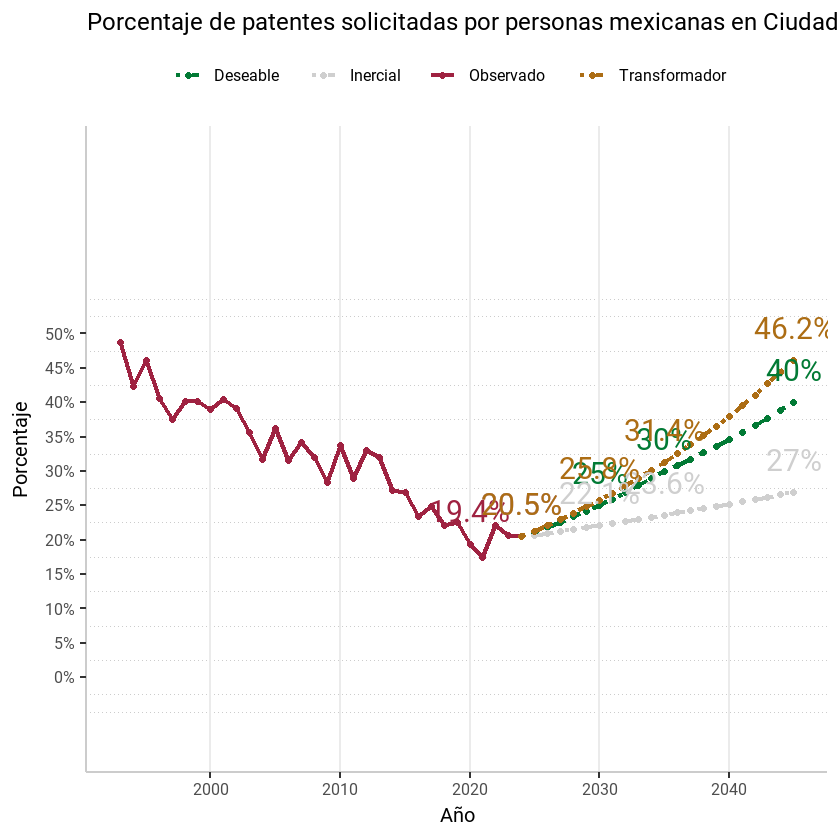

In [ ]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(impi_proy, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
geom_text(data = subset(impi_proy, ano %in% c(2020, 2024, 2030, 2035, 2045)),
          aes(label = paste0(round(porcentaje, 1), "%")),
          vjust = -1, size = 8, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(impi_proy$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(1, 1))) +
  labs(title = "Porcentaje de patentes solicitadas por personas mexicanas en Ciudad de México",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

# Guardar el gráfico
#ggsave("porcentaje_patentes_ciudad_mexico.png", width = 12, height = 8, dpi = 300)

*Porcentaje de población en pobreza por rezago educativo*

In [87]:
#Base de datos del Consejo de Evaluación de la Ciudad de México: Pobreza y Desigualdad
url <- "https://www.evalua.cdmx.gob.mx/storage/app/media/2024/die/2018-2022/NA/4-Cuadros%20MMIP%20Entidad%20Federativa%202018-2022.xlsx"
base_pobreza <- tempfile(fileext = ".xlsx")
download.file(url, base_pobreza, mode = "wb")
#Cargar la base de pobreza (Pobreza en Educación por entidad federativa)
pobreza_edu <- readxl::read_excel(base_pobreza, sheet = 8, skip = 8)

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
• `` -> `...20`
• `` -> `...21`
• `` -> `...22`
• `` -> `...23`
• `` -> `...24`
• `` -> `...25`
• `` -> `...26`
• `` -> `...27`
• `` -> `...28`
• `` -> `...29`
• `` -> `...30`
• `` -> `...31`
• `` -> `...32`
• `` -> `...33`
• `` -> `...34`
• `` -> `...35`
• `` -> `...36`
• `` -> `...37`
• `` -> `...38`
• `` -> `...39`
• `` -> `...40`
• `` -> `...41`
• `` -> `...42`
• `` -> `...43`
• `` -> `...44`
• `` -> `...45`
• `` -> `...46`
• `` -> `...47`
• `` -> `...48`
• `` -> `...49`
• `` -> `...50`
• `` -> `...51`
• `` -> `...52`
• `` -> `...53`
• `` -> `...54`
• `` -> `...55`
• `` -> `...56`
• `` -> `...57`
• `` -> `...58`
• `` -> `...59`
• `` -> `...60`
• `` -> `...61`
• `` -> `...62`
• `` -> `...63`
• `` 

In [88]:
#Preprocesamiento de la tabla de pobreza (limpieza de encabezados)
#Construcción de los encabezados
#Primera fila de encabezados: Tipo de pobreza
header1 <- pobreza_edu[2, ] |> unlist(use.names = FALSE)
header1_filled <- data.frame(valor = header1) |>
  fill(valor, .direction = "down") |>
  pull(valor) 
#Segunda fila de encabezados: Tipo de valor si es absoluto o porcentaje
header2 <- pobreza_edu[3, ] |> unlist(use.names = FALSE)
header2_filled <- data.frame(valor = header2) |>
  fill(valor, .direction = "down") |>
  pull(valor)
# Asegurarse de que el primer valor no sea NA
if (is.na(header2_filled[1])) {
  header2_filled[1] <- "E"
}
#Tercer fila de encabezados: Año de la medición
header3 <- pobreza_edu[4, ] |> unlist(use.names = FALSE)
header3_filled <- data.frame(valor = header3) |>
  fill(valor, .direction = "down") |>
  pull(valor) 
# Asegurarse de que el primer valor no sea NA
if (is.na(header3_filled[1])) {
  header3_filled[1] <- "_"
}

#Combinar los encabezados para crear nombres de columnas únicos
nombres_col <- mapply(function(h1, h2, h3) {
  partes <- na.omit(c(h1, h2, h3))
  paste(partes, collapse = "_")
}, header1_filled, header2_filled, header3_filled)
#Eliminar las filas de encabezados
pobreza_edu <- pobreza_edu[-c(1:4), ]
#Renombrar las columnas de la tabla de pobreza
colnames(pobreza_edu) <- nombres_col
#Limpiar los nombres de las columnas
pobreza_edu <- pobreza_edu |>
  janitor::clean_names()|>
  select(entidades_federativas_e, pobreza_total2_porcentaje_2018, pobreza_total2_porcentaje_2020, pobreza_total2_porcentaje_2022)|>
  mutate(across(2:4, ~ as.numeric(str_replace_all(., ",", ""))))
  
#Seleccionamos las columnas de interes, en este caso los valores de pobreza total en porcentaje para los años 2018, 2020 y 2022
pobreza_edu <- pobreza_edu |>
  
  rename(`2018` = pobreza_total2_porcentaje_2018,
         `2020` = pobreza_total2_porcentaje_2020,
         `2022` = pobreza_total2_porcentaje_2022) |>
  filter(entidades_federativas_e == "Ciudad de México") |>
  pivot_longer(cols = c(`2018`, `2020`, `2022`),
               names_to = "ano",
               values_to = "porcentaje")

# Ver resultado
pobreza_edu<-pobreza_edu|>
  mutate(ano = as.numeric(ano)) |>
  select(ano, porcentaje)|>
  mutate(tipo = "Observado")

pobreza_edu

ano,porcentaje,tipo
<dbl>,<dbl>,<chr>
2018,25.42980,Observado
2020,24.16627,Observado
2022,23.92191,Observado


In [96]:
#ESCENARIOS
#TASAS GENERLES PARA CADA PERIODO
porcentaje_base <- pobreza_edu|>
  filter(ano == 2022)|>
  pull(porcentaje)

#Tasa de crecimiento media anual para el periodo 2020-2022
ano = (2022:2045)
año_base <- 2022
tcma<-((pobreza_edu$porcentaje[pobreza_edu$ano==2022]/pobreza_edu$porcentaje[pobreza_edu$ano==2020])^(1/(2022-2020))-1)
tcma
#Metas establecidas por la SECTEI
porcentaje <- data.frame(
  ano = c(2030, 2035, 2045), 
  porcentaje = c(20, 17, 11))
#TASAS GENERLES PARA CADA PERIODO
año_bse <- pobreza_edu|>
  filter(ano == 2022)

#Tasas de cobertura para los años 2030, 2035 y 2045 (estas tasas son las metas establecidas por la SECTEI)
t2030<-porcentaje|>
filter(ano == 2030)
t2035<-porcentaje|>
filter(ano == 2035)
t2045<-porcentaje|>
filter(ano == 2045)

tc1= (t2030$porcentaje / año_bse$porcentaje)^(1 / (2030 - 2022)) - 1
tc2= (t2035$porcentaje / t2030$porcentaje)^(1 / (2035 - 2030)) - 1
tc3= (t2045$porcentaje / t2035$porcentaje)^(1 / (2045 - 2035)) - 1

tc1
tc2
tc3

[1] -0.005068718

[1] -0.02213416

[1] -0.03198121

[1] -0.0425979

In [108]:
#Proyecciones 
proyecciones_pobreza_edu <- data.frame(
  ano = 2025:2045) |>
  mutate(porcentaje = ifelse(ano < 2030,año_bse$porcentaje * (1 + tc1)^(ano - año_bse$ano),
                         ifelse(ano == 2030, t2030$porcentaje,
                                ifelse(ano < 2035, t2030$porcentaje * (1 + tc2)^(ano - t2030$ano),
                                        ifelse(ano == 2035, t2035$porcentaje,
                                                ifelse(ano < 2045, t2035$porcentaje * (1 + tc3)^(ano - t2035$ano),
                                                       ifelse(ano == 2045, t2045$porcentaje, 0)))))), 
        tipo = "Deseable")


#ESTABLECIMIENTO DE LAS TENEDENCIAS (ESCENARIO INERCIAL Y TRANSFORMADOR)
tendencia_base <- data.frame(ano = ano,
                             porcentaje = round(porcentaje_base * (1 + tcma ) ^ (ano - año_base), 2),
                             tipo = "Inercial")

tendencia_transformador <- data.frame(ano = ano,
                                       porcentaje = round(porcentaje_base * (1 + tcma* 9 ) ^ (ano - año_base), 2),
                                       tipo = "Transformador")
									   
									   
pobreza_edu_proy <- pobreza_edu |>
  select(ano, tipo, porcentaje)|>
  bind_rows(proyecciones_pobreza_edu, tendencia_base, tendencia_transformador)

  pobreza_edu_proy

ano,tipo,porcentaje
<dbl>,<chr>,<dbl>
2018,Observado,25.42980
2020,Observado,24.16627
2022,Observado,23.92191
2025,Deseable,22.36833
2026,Deseable,21.87323
2027,Deseable,21.38908
2028,Deseable,20.91565
2029,Deseable,20.45270
2030,Deseable,20.00000


In [109]:
lineas <- bind_rows(data.frame(ano = c(2022, 2030),
                               porcentaje = c(pobreza_edu_proy$porcentaje[pobreza_edu_proy$ano == 2022 & pobreza_edu_proy$tipo == "Observado"],
                                              pobreza_edu_proy$porcentaje[pobreza_edu_proy$ano == 2030 & pobreza_edu_proy$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2022, 2030),
                               porcentaje = c(pobreza_edu_proy$porcentaje[pobreza_edu_proy$ano == 2022 & pobreza_edu_proy$tipo == "Observado"], 
                                              pobreza_edu_proy$porcentaje[pobreza_edu_proy$ano == 2030 & pobreza_edu_proy$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2022, 2030),
                               porcentaje = c(pobreza_edu_proy$porcentaje[pobreza_edu_proy$ano == 2022 & pobreza_edu_proy$tipo == "Observado"], 
                                              pobreza_edu_proy$porcentaje[pobreza_edu_proy$ano == 2030 & pobreza_edu_proy$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")

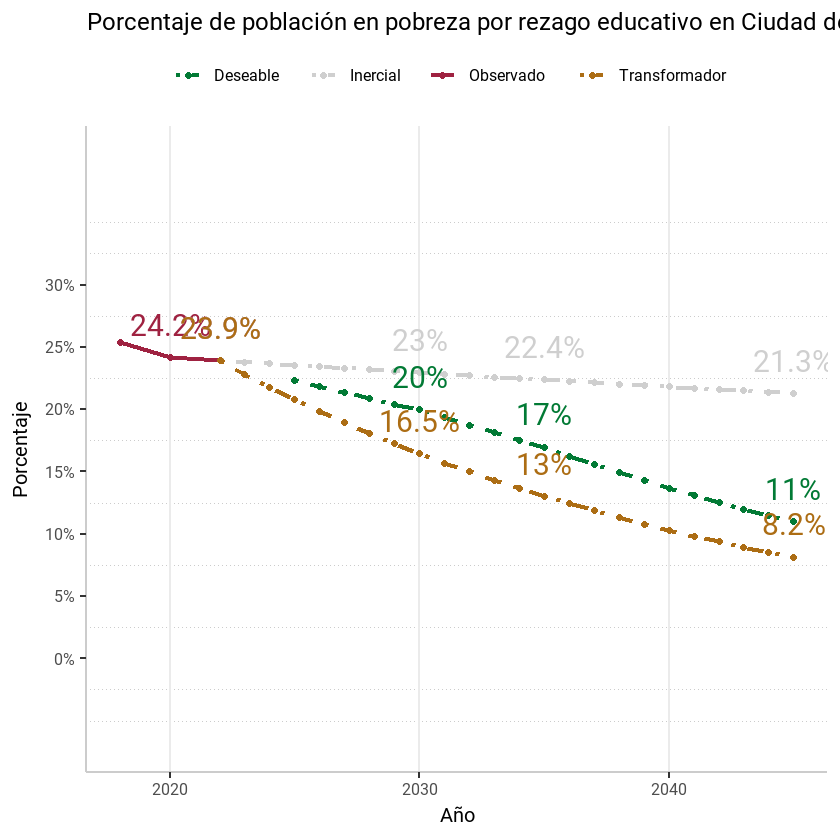

In [ ]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(pobreza_edu_proy, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
geom_text(data = subset(pobreza_edu_proy, ano %in% c(2020, 2022, 2030, 2035, 2045)),
          aes(label = paste0(round(porcentaje, 1), "%")),
          vjust = -1, size = 8, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(pobreza_edu_proy$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(1, 1))) +
  labs(title = "Porcentaje de población en pobreza por rezago educativo en Ciudad de México",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

# Guardar el gráfico
#ggsave("pobreza_educacion_ciudad_mexico.png", width = 12, height = 8, dpi = 300)

*Porcentaje de población de 15 años y más en rezago educativo*

In [111]:
leer_rezago <- function(anio) { 
  # URLs de descarga para los años disponibles
  urls <- list(
    "2019" = "https://www.gob.mx/cms/uploads/attachment/file/976879/est_rez_2019_actualizado.xlsx", 
    "2020" = "https://www.gob.mx/cms/uploads/attachment/file/976878/est_rez_2020_actualizado.xlsx", 
    "2021" = "https://www.gob.mx/cms/uploads/attachment/file/976880/est_rez_2021_actualizado.xlsx", 
    "2022" = "https://www.gob.mx/cms/uploads/attachment/file/976881/est_rez_2022_actualizado.xlsx", 
    "2023" = "https://www.gob.mx/cms/uploads/attachment/file/976882/est_rez_2023_actualizado.xlsx", 
    "2024" = "https://www.gob.mx/cms/uploads/attachment/file/976883/est_rez_2024_actualizado.xlsx"
  )

  #  URL del año
  url <- urls[[as.character(anio)]]
  
  # Descargar el archivo y guardarlo en un archivo temporal
  archivo_temp <- tempfile(fileext = ".xlsx")
  download.file(url, destfile = archivo_temp, mode = "wb")
  
  # Leer el archivo desde la hoja especificada
  rez_edu <- readxl::read_excel(archivo_temp, skip = 8)|>
    janitor::clean_names()
  
  return(rez_edu)
}

In [115]:
# Leer los datos de rezago 
rz2019 <- leer_rezago(2019)
rz2020 <- leer_rezago(2020)
rz2021 <- leer_rezago(2021)
rz2022 <- leer_rezago(2022)
rz2023 <- leer_rezago(2023)
rz2024 <- leer_rezago(2024)


New names:
• `` -> `...2`
• `Lugar` -> `Lugar...5`
• `%` -> `%...6`
• `Lugar` -> `Lugar...7`
• `Lugar` -> `Lugar...9`
• `%` -> `%...10`
• `Lugar` -> `Lugar...11`
• `Lugar` -> `Lugar...13`
• `%` -> `%...14`
• `Lugar` -> `Lugar...15`
• `Lugar` -> `Lugar...17`
• `%` -> `%...18`
• `Lugar` -> `Lugar...19`
New names:
• `` -> `...2`
• `Lugar` -> `Lugar...5`
• `%` -> `%...6`
• `Lugar` -> `Lugar...7`
• `Lugar` -> `Lugar...9`
• `%` -> `%...10`
• `Lugar` -> `Lugar...11`
• `Lugar` -> `Lugar...13`
• `%` -> `%...14`
• `Lugar` -> `Lugar...15`
• `Lugar` -> `Lugar...17`
• `%` -> `%...18`
• `Lugar` -> `Lugar...19`
New names:
• `` -> `...2`
• `Lugar` -> `Lugar...5`
• `%` -> `%...6`
• `Lugar` -> `Lugar...7`
• `Lugar` -> `Lugar...9`
• `%` -> `%...10`
• `Lugar` -> `Lugar...11`
• `Lugar` -> `Lugar...13`
• `%` -> `%...14`
• `Lugar` -> `Lugar...15`
• `Lugar` -> `Lugar...17`
• `%` -> `%...18`
• `Lugar` -> `Lugar...19`
New names:
• `` -> `...2`
• `Lugar` -> `Lugar...5`
• `%` -> `%...6`
• `Lugar` -> `Lugar...7`
•

In [116]:

rz2019 <- rz2019[-1,-1]|>
  rename(Entidad = x2)|>
  filter(Entidad == "Ciudad de México")|>
  mutate(ano = 2019)|>
  select(ano,percent_18)

rz2020 <- rz2020[-1,-1]|>
  rename(Entidad = x2)|>
  filter(Entidad == "Ciudad de México")|>
  mutate(ano = 2020)|>
  select(ano,percent_18)

rz2021 <- rz2021[-1,-1]|>
  rename(Entidad = x2)|>
  filter(Entidad == "Ciudad de México")|>
  mutate(ano = 2021)|>
  select(ano,percent_18)

rz2022 <- rz2022[-1,-1]|>
  rename(Entidad = x2)|>
  filter(Entidad == "Ciudad de México")|>
  mutate(ano = 2022)|>
  select(ano,percent_18)

rz2023 <- rz2023[-1,-1]|>
  rename(Entidad = x2)|>
  filter(Entidad == "Ciudad de México")|>
  mutate(ano = 2023)|>
  select(ano,percent_18)

rz2024 <- rz2024[-1,-1]|>
  rename(Entidad = x2)|>
  filter(Entidad == "Ciudad de México")|>
  mutate(ano = 2024)|>
  select(ano,percent_18)


rezago_educacion<-rz2019|>
  bind_rows(rz2020, rz2021, rz2022, rz2023, rz2024)|>  
  rename(porcentaje = percent_18)|>
  mutate(porcentaje = round(porcentaje, 1),
          tipo = "Observado")

rezago_educacion

ano,porcentaje,tipo
<dbl>,<dbl>,<chr>
2019,18.0,Observado
2020,18.0,Observado
2021,17.8,Observado
2022,17.4,Observado
2023,16.9,Observado
2024,17.0,Observado


In [127]:
#ESCENARIOS
#TASAS GENERLES PARA CADA PERIODO
porcentaje_base <- rezago_educacion|>
  filter(ano == 2024)|>
  pull(porcentaje)

#Tasa de crecimiento media anual para el periodo 2020-2024
ano = (2024:2045)
año_base <- 2024
tcma<-((rezago_educacion$porcentaje[rezago_educacion$ano==2024]/rezago_educacion$porcentaje[rezago_educacion$ano==2020])^(1/(2024-2020))-1)
tcma
#Metas establecidas por la SECTEI
porcentaje <- data.frame(
  ano = c(2030, 2035, 2045), 
  porcentaje = c(15, 13, 9))
#TASAS GENERLES PARA CADA PERIODO
año_bse <- rezago_educacion|>
  filter(ano == 2024)

#Tasas de cobertura para los años 2030, 2035 y 2045 (estas tasas son las metas establecidas por la SECTEI)
t2030<-porcentaje|>
filter(ano == 2030)
t2035<-porcentaje|>
filter(ano == 2035)
t2045<-porcentaje|>
filter(ano == 2045)

tc1= (t2030$porcentaje / año_bse$porcentaje)^(1 / (2030 - 2024)) - 1
tc2= (t2035$porcentaje / t2030$porcentaje)^(1 / (2035 - 2030)) - 1
tc3= (t2045$porcentaje / t2035$porcentaje)^(1 / (2045 - 2035)) - 1

tc1
tc2
tc3

[1] -0.01418799

[1] -0.02064445

[1] -0.02821449

[1] -0.03610458

In [128]:
#Proyecciones 
proyecciones_rezago_educacion <- data.frame(
  ano = 2025:2045) |>
  mutate(porcentaje = ifelse(ano < 2030,año_bse$porcentaje * (1 + tc1)^(ano - año_bse$ano),
                         ifelse(ano == 2030, t2030$porcentaje,
                                ifelse(ano < 2035, t2030$porcentaje * (1 + tc2)^(ano - t2030$ano),
                                        ifelse(ano == 2035, t2035$porcentaje,
                                                ifelse(ano < 2045, t2035$porcentaje * (1 + tc3)^(ano - t2035$ano),
                                                       ifelse(ano == 2045, t2045$porcentaje, 0)))))), 
          tipo = "Deseable")


#ESTABLECIMIENTO DE LAS TENEDENCIAS (ESCENARIO INERCIAL Y TRANSFORMADOR)
tendencia_base <- data.frame(ano = ano,
                             porcentaje = round(porcentaje_base * (1 + tcma ) ^ (ano - año_base), 2),
                             tipo = "Inercial")

tendencia_transformador <- data.frame(ano = ano,
                                       porcentaje = round(porcentaje_base * (1 + tcma*4) ^ (ano - año_base), 2),
                                       tipo = "Transformador")
									   
									   
rezago_educacion_proy <- rezago_educacion |>
  select(ano, tipo, porcentaje)|>
  bind_rows(proyecciones_rezago_educacion, tendencia_base, tendencia_transformador)

rezago_educacion_proy


ano,tipo,porcentaje
<dbl>,<chr>,<dbl>
2019,Observado,18.000000
2020,Observado,18.000000
2021,Observado,17.800000
2022,Observado,17.400000
2023,Observado,16.900000
2024,Observado,17.000000
2025,Deseable,16.649044
2026,Deseable,16.305334
2027,Deseable,15.968719


In [129]:
lineas <- bind_rows(data.frame(ano = c(2024, 2030),
                               porcentaje = c(rezago_educacion_proy$porcentaje[rezago_educacion_proy$ano == 2024 & rezago_educacion_proy$tipo == "Observado"],
                                              rezago_educacion_proy$porcentaje[rezago_educacion_proy$ano == 2030 & rezago_educacion_proy$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(rezago_educacion_proy$porcentaje[rezago_educacion_proy$ano == 2024 & rezago_educacion_proy$tipo == "Observado"], 
                                              rezago_educacion_proy$porcentaje[rezago_educacion_proy$ano == 2030 & rezago_educacion_proy$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(rezago_educacion_proy$porcentaje[rezago_educacion_proy$ano == 2024 & rezago_educacion_proy$tipo == "Observado"], 
                                              rezago_educacion_proy$porcentaje[rezago_educacion_proy$ano == 2030 & rezago_educacion_proy$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")

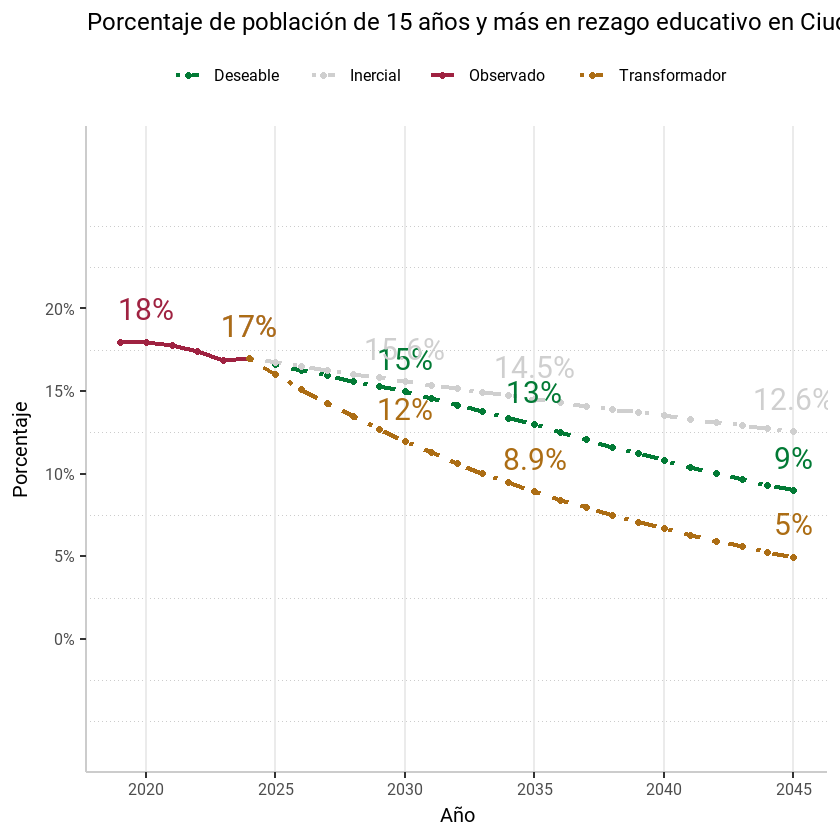

In [130]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(rezago_educacion_proy, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
geom_text(data = subset(rezago_educacion_proy, ano %in% c(2020, 2024, 2030, 2035, 2045)),
          aes(label = paste0(round(porcentaje, 1), "%")),
          vjust = -1, size = 8, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(rezago_educacion_proy$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(1, 1))) +
  labs(title = "Porcentaje de población de 15 años y más en rezago educativo en Ciudad de México",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

# Guardar el gráfico

*Porcentaje de integrantes del SNII en áreas del conocimiento STEM*

In [131]:
leer_snii <- function(anio) {
  # URLs de descarga para los años disponibles
  urls <- list(
    "2018" = "https://secihti.mx/wp-content/uploads/sni/archivo_historico/Investigadores_Vigentes_2018.xlsx",
    "2019" = "https://secihti.mx/wp-content/uploads/sni/archivo_historico/Investigadores_Vigentes_2019.xlsx", 
    "2020" = "https://secihti.mx/wp-content/uploads/sni/archivo_historico/Investigadores_Vigentes_2020.xlsx", 
    "2021" = "https://secihti.mx/wp-content/uploads/sni/archivo_historico/Padron_de_Beneficiarios_2021.xlsx", 
    "2022" = "https://secihti.mx/wp-content/uploads/sni/padron_de_beneficiarios/2022/Padron_de_Beneficiarios_2022_actualizado_julio_2.xlsx", 
    "2023" = "https://secihti.mx/wp-content/uploads/sni/archivo_historico/Investigadores_vigentes_2023.xlsx", 
    "2024" = "https://secihti.mx/wp-content/uploads/sni/archivo_historico/Padron_de_Investigadores_Vigentes_2024.xlsx"
  )
  
  # Obtener URL correspondiente
  url <- urls[[as.character(anio)]]
  if (is.null(url)) stop("Año no disponible.")
  
  # Descargar archivo temporal
  archivo_temp <- tempfile(fileext = ".xlsx")
  download.file(url, destfile = archivo_temp, mode = "wb")
  
  # Leer según el año
  if (anio == 2022) {
    reg_snii <- readxl::read_excel(archivo_temp, sheet = 3, col_types = "text") |> 
      janitor::clean_names()
    
  } else if (anio %in% c(2023, 2024)) {
    reg_snii <- readxl::read_excel(archivo_temp, sheet = 4, col_types = "text") |> 
      janitor::clean_names()
    
  } else {
    hojas <- readxl::excel_sheets(archivo_temp)
    reg_snii <- lapply(hojas, function(hoja) {
      readxl::read_excel(archivo_temp, sheet = hoja, col_types = "text") |> 
        janitor::clean_names()
    }) |> 
      dplyr::bind_rows()
  }
  
  return(reg_snii)
}

In [132]:
#Leer las bases del SNI de los años 2018 a 2024
snii2018 <-leer_snii(2018)|>
  filter(area_del_conocimiento %in% c("I.- FÍSICO-MATEMÁTICAS Y CIENCIAS DE LA TIERRA",
                                      "II.- BIOLOGÍA Y QUÍMICA", 
                                      "III.- MEDICINA Y CIENCIAS DE LA SALUD", 
                                      "VII.- INGENIERÍAS"))

snii2019 <-leer_snii(2019)|>
  filter(area_del_conocimiento %in% c("I.- FÍSICO-MATEMÁTICAS Y CIENCIAS DE LA TIERRA",
                                      "II.- BIOLOGÍA Y QUÍMICA", 
                                      "III.- MEDICINA Y CIENCIAS DE LA SALUD", 
                                      "VII.- INGENIERÍAS"))
snii2020 <-leer_snii(2020)|>
  filter(area_del_conocimiento %in% c("I.- FÍSICO-MATEMÁTICAS Y CIENCIAS DE LA TIERRA",
                                      "II.- BIOLOGÍA Y QUÍMICA", 
                                      "III.- MEDICINA Y CIENCIAS DE LA SALUD", 
                                      "VII.- INGENIERÍAS"))
snii2021 <-leer_snii(2021)|>
  filter(area_del_conocimiento %in% c("I.- FÍSICO-MATEMÁTICAS Y CIENCIAS DE LA TIERRA",
                                      "II.- BIOLOGÍA Y QUÍMICA", 
                                      "III.- MEDICINA Y CIENCIAS DE LA SALUD", 
                                      "VII.- INGENIERÍAS"))
snii2022 <-leer_snii(2022)|>
  filter(area_del_conocimiento %in% c("I.- FÍSICO-MATEMÁTICAS Y CIENCIAS DE LA TIERRA",
                                      "II.- BIOLOGÍA Y QUÍMICA", 
                                      "III.- MEDICINA Y CIENCIAS DE LA SALUD", 
                                      "VIII.- INGENIERÍAS Y DESARROLLO TECNOLÓGICO", 
                                      "Físico-Matemáticas y Ciencias de la Tierra", 
                                      "Medicina y Ciencias de la Salud",
                                      "Biología y Química"))

snii2023 <-leer_snii(2023)|>
  filter(area_del_conocimiento %in% c("FÍSICO-MATEMÁTICAS Y CIENCIAS DE LA TIERRA",
                                      "BIOLOGÍA Y QUÍMICA", 
                                      "MEDICINA Y CIENCIAS DE LA SALUD", 
                                      "INGENIERÍAS Y DESARROLLO TECNOLÓGICO"))
snii2024 <-leer_snii(2024)|>
  filter(area_de_conocimiento %in% c("FÍSICO-MATEMÁTICAS Y CIENCIAS DE LA TIERRA",
                                      "BIOLOGÍA Y QUÍMICA", 
                                      "MEDICINA Y CIENCIAS DE LA SALUD", 
                                      "INGENIERÍAS Y DESARROLLO TECNOLÓGICO"))

In [133]:
#Obtener los totales nacionales y de la Ciudad de México
snii2018_nac<-snii2018|>
  summarise(nacional = n())|>
  mutate(ano = 2018)

snii2018_nac

snii2019_nac<-snii2019|>
  summarise(nacional = n())|>
  mutate(ano = 2019)

snii2020_nac<-snii2020|>
  summarise(nacional = n())|>
  mutate(ano = 2020)

snii2021_nac<-snii2021|>
  summarise(nacional = n())|>
  mutate(ano = 2021)

snii2022_nac<-snii2022|>
  summarise(nacional = n())|>
  mutate(ano = 2022)

snii2023_nac<-snii2023|>
  summarise(nacional = n())|>
  mutate(ano = 2023)

snii2024_nac<-snii2024|>
  summarise(nacional = n())|>
  mutate(ano = 2024)

nacional_snii<-snii2018_nac|>
  bind_rows(snii2019_nac,snii2020_nac, snii2021_nac,snii2022_nac, snii2023_nac, snii2024_nac)

nacional_snii

snii2018_cdmx<-snii2018|>
  group_by(entidad_federativa)|>
  summarise(cdmx = n())|>
  filter(entidad_federativa=="CIUDAD DE MÉXICO")|>
  mutate(ano = 2018)

snii2018_cdmx

snii2019_cdmx<-snii2019|>
  group_by(entidad_federativa)|>
  summarise(cdmx = n())|>
  filter(entidad_federativa=="CIUDAD DE MÉXICO")|>
  mutate(ano = 2019)

snii2020_cdmx<-snii2020|>
  group_by(entidad_federativa)|>
  summarise(cdmx = n())|>
  filter(entidad_federativa=="CIUDAD DE MÉXICO")|>
  mutate(ano = 2020)

snii2021_cdmx<-snii2021|>
  group_by(entidad_federativa)|>
  summarise(cdmx = n())|>
  filter(entidad_federativa=="CIUDAD DE MÉXICO")|>
  mutate(ano = 2021)

snii2022_cdmx<-snii2022|>
  group_by(entidad_federativa_de_adscripcion)|>
  summarise(cdmx = n())|>
  filter(entidad_federativa_de_adscripcion=="CIUDAD DE MÉXICO")|>
  mutate(ano = 2022)

snii2023_cdmx<-snii2023|>
  group_by(entidad_federativa_de_adscripcion)|>
  summarise(cdmx = n())|>
  filter(entidad_federativa_de_adscripcion=="CIUDAD DE MÉXICO")|>
  mutate(ano = 2023)
         
snii2024_cdmx<-snii2024|>
  group_by(entidad_de_acreditacion)|>
  summarise(cdmx = n())|>
  filter(entidad_de_acreditacion=="CIUDAD DE MÉXICO")|>
  mutate(ano = 2024)

cdmx_snii<-snii2018_cdmx|>
  bind_rows(snii2019_cdmx,snii2020_cdmx, snii2021_cdmx,snii2022_cdmx, snii2023_cdmx,snii2024_cdmx)|>
  select(ano, cdmx)

cdmx_snii

nacional,ano
<int>,<dbl>
16280,2018


nacional,ano
<int>,<dbl>
16280,2018
17243,2019
18445,2020
19343,2021
19554,2022
21702,2023
22414,2024


entidad_federativa,cdmx,ano
<chr>,<int>,<dbl>
CIUDAD DE MÉXICO,5217,2018


ano,cdmx
<dbl>,<int>
2018,5217
2019,5297
2020,5427
2021,5594
2022,6645
2023,7903
2024,8063


In [ ]:
#Porcentaje de integrantes del SNII en áreas del conocimiento STEM
porcentaje_part_snii<-nacional_snii|>
  left_join(cdmx_snii, by = "ano")|>
  mutate(porcentaje = (cdmx*100)/nacional,
          tipo = "Observado")

porcentaje_part_snii

nacional,ano,cdmx,porcentaje,tipo
<int>,<dbl>,<int>,<dbl>,<chr>
16280,2018,5217,32.04545,Observado
17243,2019,5297,30.71971,Observado
18445,2020,5427,29.42261,Observado
19343,2021,5594,28.92002,Observado
19554,2022,6645,33.98282,Observado
21702,2023,7903,36.41600,Observado
22414,2024,8063,35.97305,Observado


In [136]:
#ESCENARIOS
#TASAS GENERLES PARA CADA PERIODO
porcentaje_base <- porcentaje_part_snii|>
  filter(ano == 2024)|>
  pull(porcentaje)

#Tasa de crecimiento media anual para el periodo 2020-2024
ano = (2024:2045)
año_base <- 2024
tcma<-((porcentaje_part_snii$porcentaje[porcentaje_part_snii$ano==2024]/porcentaje_part_snii$porcentaje[porcentaje_part_snii$ano==2020])^(1/(2024-2020))-1)
tcma
#Metas establecidas por la SECTEI
porcentaje <- data.frame(
  ano = c(2030, 2035, 2045), 
  porcentaje = c(40, 44, 52))
#TASAS GENERLES PARA CADA PERIODO
año_bse <- porcentaje_part_snii|>
  filter(ano == 2024)

#Tasas de cobertura para los años 2030, 2035 y 2045 (estas tasas son las metas establecidas por la SECTEI)
t2030<-porcentaje|>
filter(ano == 2030)
t2035<-porcentaje|>
filter(ano == 2035)
t2045<-porcentaje|>
filter(ano == 2045)

tc1= (t2030$porcentaje / año_bse$porcentaje)^(1 / (2030 - 2024)) - 1
tc2= (t2035$porcentaje / t2030$porcentaje)^(1 / (2035 - 2030)) - 1
tc3= (t2045$porcentaje / t2035$porcentaje)^(1 / (2045 - 2035)) - 1

tc1
tc2
tc3

[1] 0.05153573

[1] 0.01784219

[1] 0.01924488

[1] 0.01684572

In [139]:
#Proyecciones 
proyecciones_porcentaje_part_snii <- data.frame(
  ano = 2025:2045) |>
  mutate(porcentaje = ifelse(ano < 2030,año_bse$porcentaje * (1 + tc1)^(ano - año_bse$ano),
                         ifelse(ano == 2030, t2030$porcentaje,
                                ifelse(ano < 2035, t2030$porcentaje * (1 + tc2)^(ano - t2030$ano),
                                        ifelse(ano == 2035, t2035$porcentaje,
                                                ifelse(ano < 2045, t2035$porcentaje * (1 + tc3)^(ano - t2035$ano),
                                                       ifelse(ano == 2045, t2045$porcentaje, 0)))))),

        tipo = "Deseable")


#ESTABLECIMIENTO DE LAS TENEDENCIAS (ESCENARIO INERCIAL Y TRANSFORMADOR)
tendencia_base <- data.frame(ano = ano,
                             porcentaje = round(porcentaje_base * (1 + 1/3*tcma ) ^ (ano - año_base), 2),
                             tipo = "Inercial")

tendencia_transformador <- data.frame(ano = ano,
                                       porcentaje = round(porcentaje_base * (1 + 1/2*tcma ) ^ (ano - año_base), 2),
                                       tipo = "Transformador")
									   
									   
snii <- porcentaje_part_snii |>
  select(ano, tipo, porcentaje)|>
  bind_rows(proyecciones_porcentaje_part_snii, tendencia_base, tendencia_transformador)

snii


ano,tipo,porcentaje
<dbl>,<chr>,<dbl>
2018,Observado,32.04545
2019,Observado,30.71971
2020,Observado,29.42261
2021,Observado,28.92002
2022,Observado,33.98282
2023,Observado,36.41600
2024,Observado,35.97305
2025,Deseable,36.61489
2026,Deseable,37.26818


In [ ]:
lineas <- bind_rows(data.frame(ano = c(2024, 2030),
                               porcentaje = c(porcentaje_part_snii_proy$porcentaje[porcentaje_part_snii_proy$ano == 2024 & porcentaje_part_snii_proy$tipo == "Observado"],
                                              porcentaje_part_snii_proy$porcentaje[porcentaje_part_snii_proy$ano == 2030 & porcentaje_part_snii_proy$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(porcentaje_part_snii_proy$porcentaje[porcentaje_part_snii_proy$ano == 2024 & porcentaje_part_snii_proy$tipo == "Observado"], 
                                              porcentaje_part_snii_proy$porcentaje[porcentaje_part_snii_proy$ano == 2030 & porcentaje_part_snii_proy$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(ano = c(2024, 2030),
                               porcentaje = c(porcentaje_part_snii_proy$porcentaje[porcentaje_part_snii_proy$ano == 2024 & porcentaje_part_snii_proy$tipo == "Observado"], 
                                              porcentaje_part_snii_proy$porcentaje[porcentaje_part_snii_proy$ano == 2030 & porcentaje_part_snii_proy$tipo == "Transformador"]),
                               tipo = "Transformador"))

paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash"

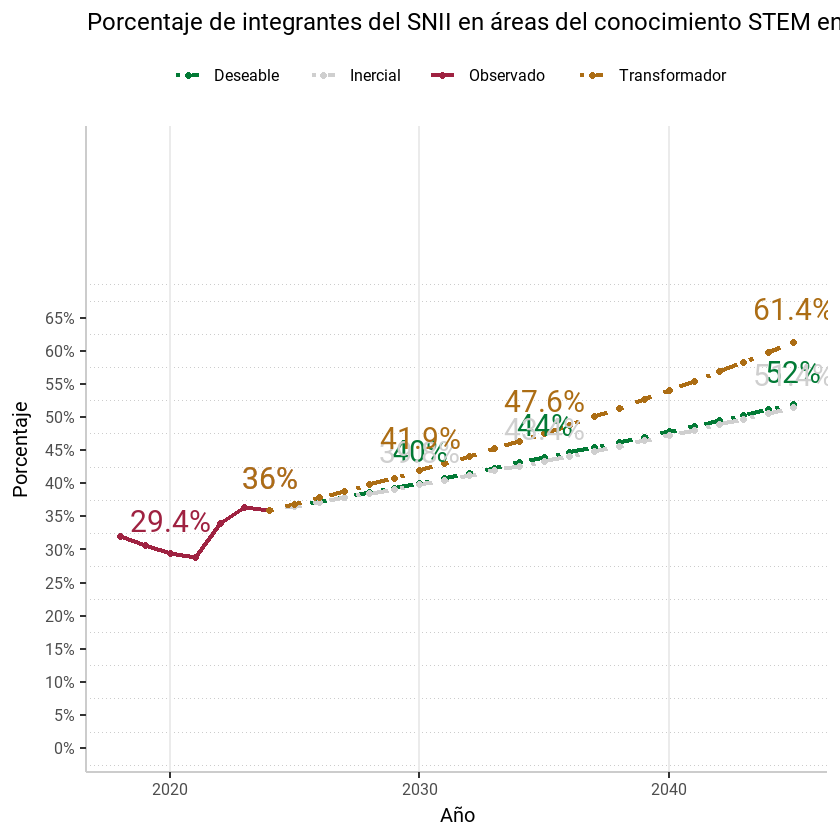

In [ ]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(snii, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
geom_text(data = subset(snii, ano %in% c(2020, 2024, 2030, 2035, 2045)),
          aes(label = paste0(round(porcentaje, 1), "%")),
          vjust = -1, size = 8, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(snii$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(1, 1))) +
  labs(title = "Porcentaje de integrantes del SNII en áreas del conocimiento STEM en Ciudad de México",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

# Guardar el gráfico
#ggsave("snii_stem_ciudad_mexico.png", width = 12, height = 8, dpi = 300)
